In [1]:
import numpy as np
import pandas as pd
from astropy.table import Table, vstack
from matplotlib import pyplot as plt
from glob import glob
from astropy.stats import LombScargle
from scipy import stats
import warnings
from TESStools import *
from astroML.time_series import ACF_scargle,ACF_EK

In [2]:
tic = 29984014

/Volumes/shoobert/Research/UW/TESS/code/TESStools.py:111: RankWarning: Polyfit may be poorly conditioned
  p = np.polyfit(lc['Time'].values,lc['Flux'].values,deg=deg)


[Text(0, 0.5, 'Normalized PDCSAP\\_FLUX [$e^-/s$]'),
 Text(0.5, 0, 'BJD - 2457000 [$d$]')]

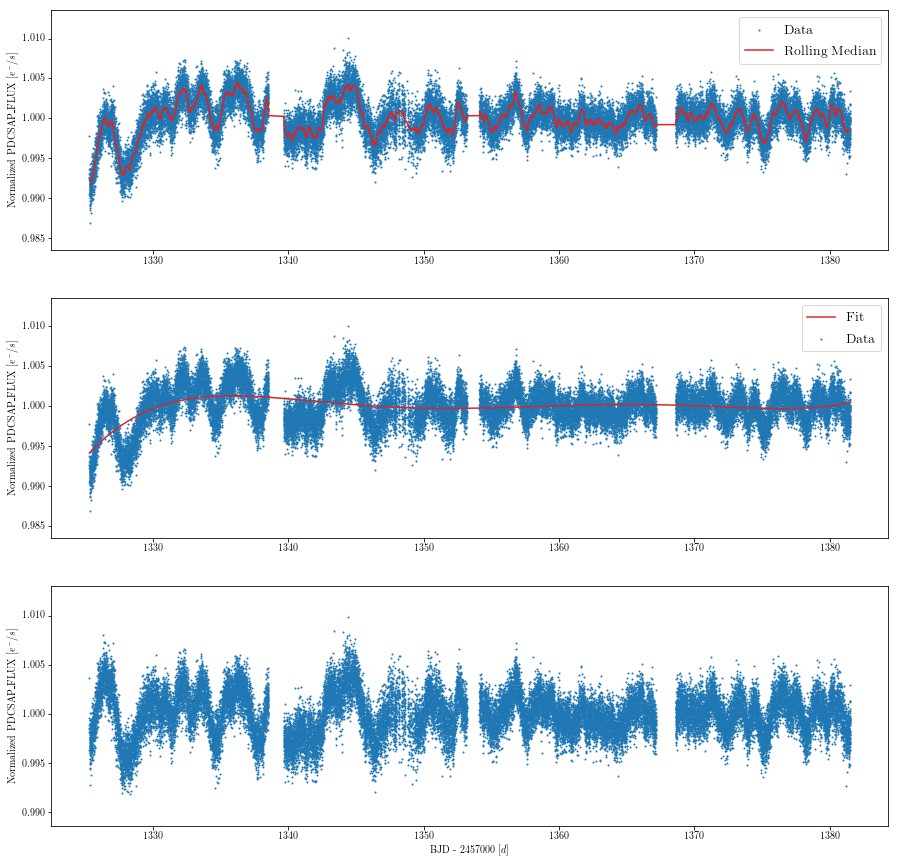

In [3]:
# we need to normalize the light curve here.
fig, ax = plt.subplots(3, figsize=(15,15))
lc, lc_smooth = lc_extract(get_lc_from_id(tic), smooth=128)
ax[0].scatter(lc['Time'],lc['Flux'],s=1,label='Data')
ax[0].plot(lc_smooth['Time'],lc_smooth['Flux'],c='C3',label='Rolling Median')
ax[0].set(ylabel='Normalized PDCSAP\_FLUX [$e^-/s$]')
h, l = ax[0].get_legend_handles_labels()
ax[0].legend(handles = h[::-1], labels = l[::-1], prop={'size': 14})

lc, p = polynorm(lc, deg=7)

vals = np.polyval(p, lc['Time'])
ax[1].scatter(lc['Time'],lc['Flux'],s=1,label='Data')
ax[1].plot(lc['Time'],vals,c='C3',label='Fit')
ax[1].set(ylabel='Normalized PDCSAP\_FLUX [$e^-/s$]')
h, l = plt.gca().get_legend_handles_labels()
ax[1].legend(handles = h[::-1], labels = l[::-1], prop={'size': 14})


ax[2].scatter(lc['Time'],lc['NormFlux'],s=1)
ax[2].set(xlabel='BJD - 2457000 [$d$]', ylabel='Normalized PDCSAP\_FLUX [$e^-/s$]')

In [4]:
time, flux, err = lc['Time'], lc['NormFlux'], lc['NormErr']

pseudo_NF = 0.5 / (np.mean(np.diff(time)))
ls = LombScargle(time, flux, normalization='psd')
freq, power = ls.autopower(minimum_frequency=1.0/30.0,
                    maximum_frequency=pseudo_NF) 

good_fs, good_amps, good_phases = prewhiten(time, flux, err)
harmonics = harmonic_search(good_fs)

f_Ny = 323.83746567083887, f_R = 0.017787891882718898
10
20
30
40
50
60
Found 64 frequencies
33 unique frequencies


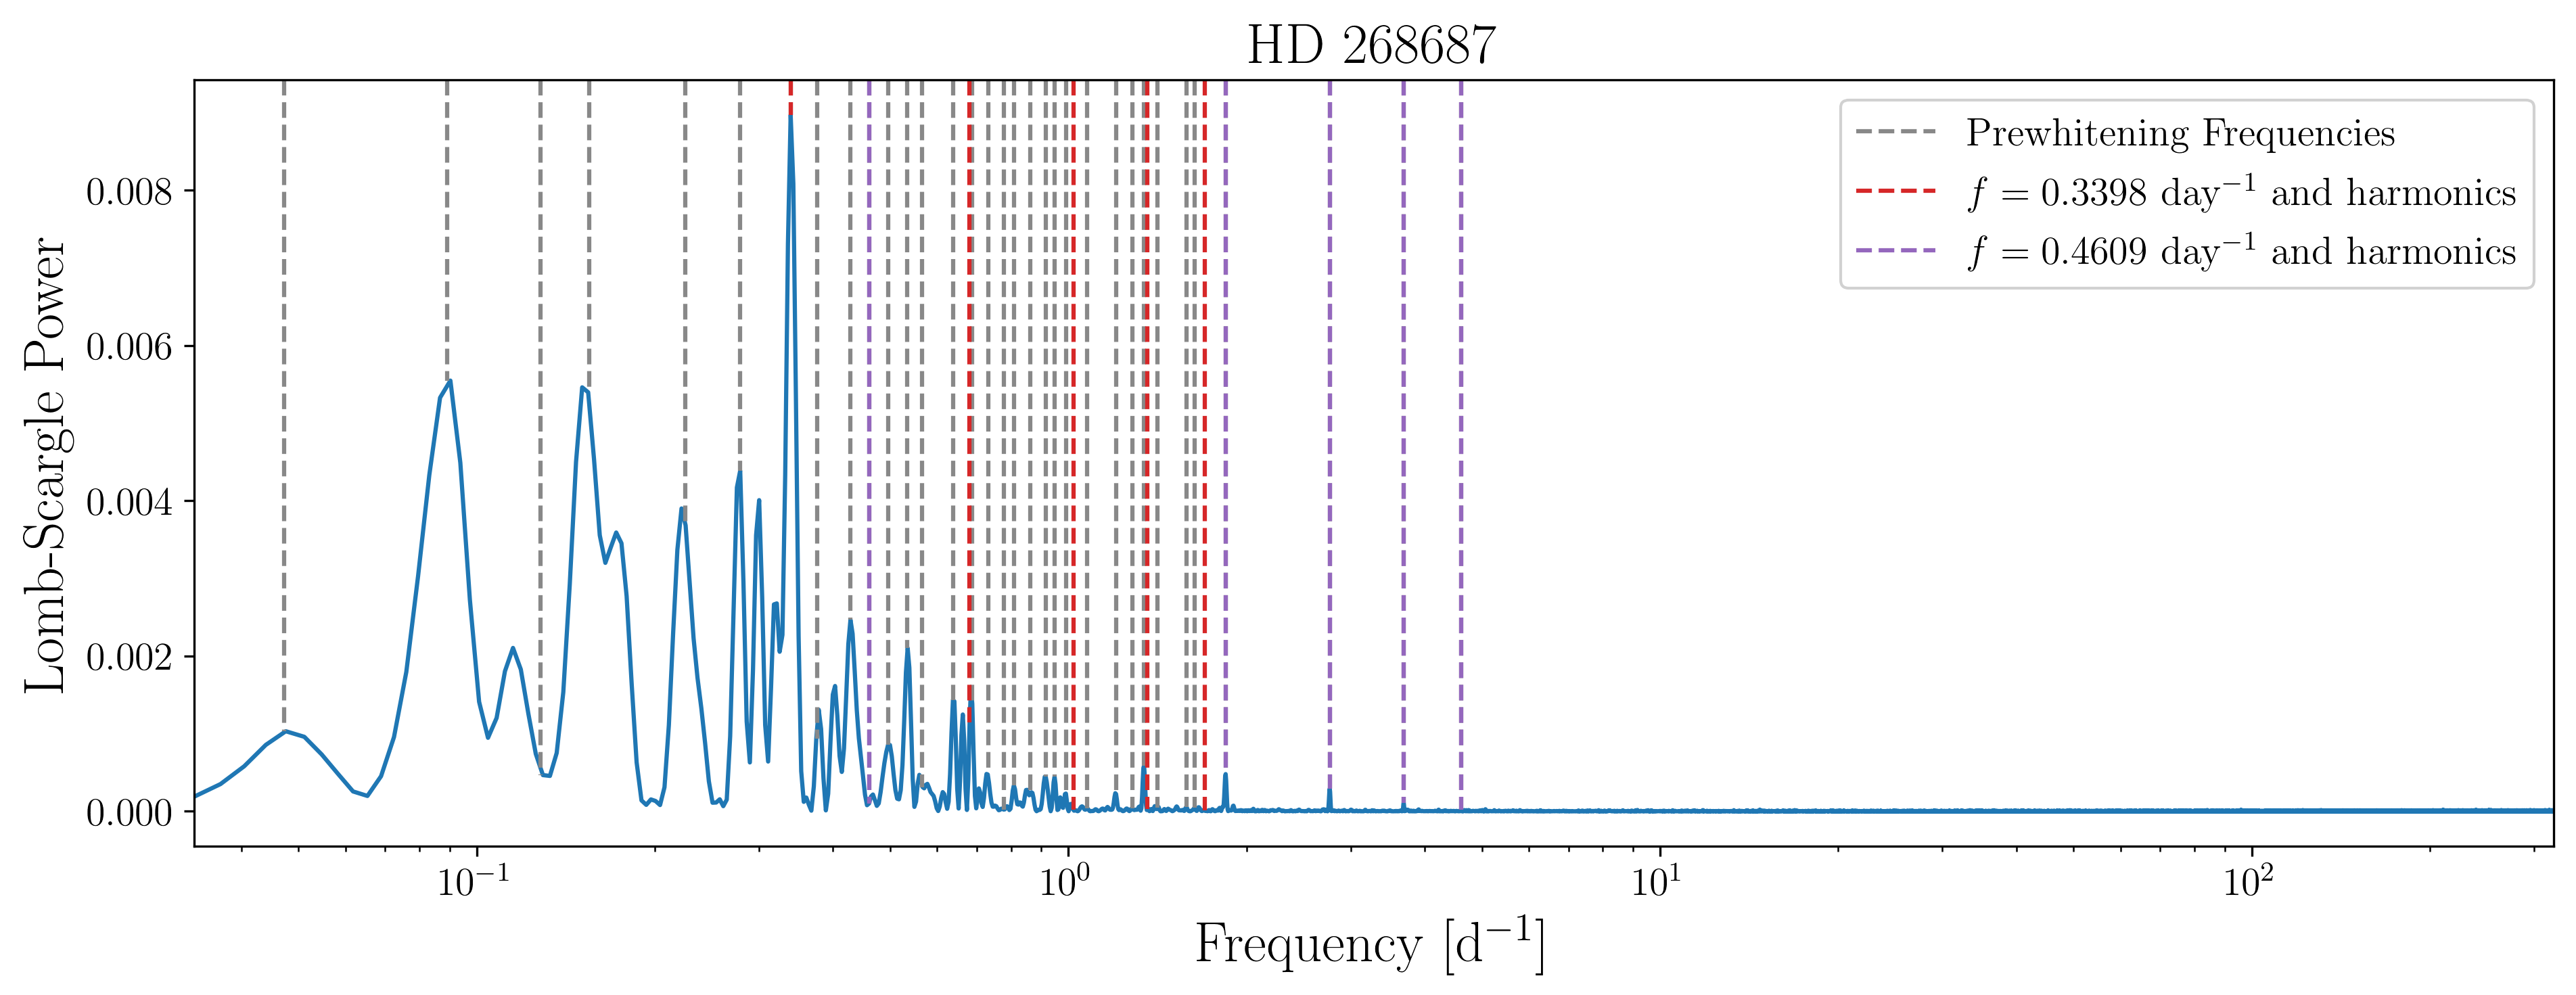

In [5]:
fig = plt.figure(figsize=(15,5),dpi=300)

plt.plot(freq, power)

ax = plt.gca()

ax.set(xlabel='Frequency [d$^{-1}$]', ylabel='Lomb-Scargle Power', xscale='log', xlim=(1/30,pseudo_NF))

ylim = ax.get_ylim()

plt.plot([good_fs[0,0],good_fs[0,0]],[ylim[1],power[np.argmin(np.abs(freq-good_fs[0,0]))]],c='#888888',ls='--',label='Prewhitening Frequencies')
for f in good_fs[1:,0]:
    plt.plot([f,f],[ylim[1],power[np.argmin(np.abs(freq-f))]],c='#888888',ls='--')
 
dom = 0.3398155918857977
plt.plot([dom,dom],[ylim[1],power[np.argmin(np.abs(freq-dom))]],c='C3',ls='--',label='$f=0.3398$ day$^{-1}$ and harmonics')
for i in range(2,6):
    plt.plot([i*dom,i*dom],[ylim[1],power[np.argmin(np.abs(freq-i*dom))]],c='C3',ls='--')
    
fund = harmonics[0,6]
harms = harmonics[1,6:]
plt.plot([fund,fund],[ylim[1],power[np.argmin(np.abs(freq-fund))]],c='C4',ls='--',label='$f=0.4609$ day$^{-1}$ and harmonics')
for h in harms:
    plt.plot([h,h],[ylim[1],power[np.argmin(np.abs(freq-h))]],c='C4',ls='--')
   
    
ax.set(ylim=ylim)
        
plt.legend(loc=1, framealpha=0.9, prop={'size': 14})

ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)

ax.set_title('HD 268687',fontsize=20)    
plt.savefig('../plots/HD268687_periodogram.pdf')

/Users/carina/anaconda/lib/python3.5/site-packages/astroML/time_series/ACF.py:133: RuntimeWarning: invalid value encountered in true_divide
  ACF /= M
/Users/carina/anaconda/lib/python3.5/site-packages/astroML/time_series/ACF.py:135: RuntimeWarning: divide by zero encountered in true_divide
  return ACF, np.sqrt(2. / M), bins
/Volumes/shoobert/Research/UW/TESS/code/TESStools.py:73: RuntimeWarning: invalid value encountered in greater
  if np.all(p[i] > p[i -width:i])&np.all(p[i] > p[i + 1:i+width+1])&(p[i]>FAL):


[0.06181388 0.1909334  0.12508592 0.25312258 0.58976342]


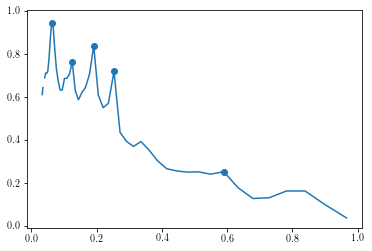

In [6]:
C_EK, C_EK_err, bins = ACF_EK(freq[freq<=1], power[freq<=1], 0.001*power[freq<=1], bins=np.logspace(-1.5, 0, 50))
f_EK = 0.5 * (bins[1:] + bins[:-1])
plt.plot(f_EK,C_EK)
f,p = peak_finder(f_EK,C_EK,10,width=3)
plt.scatter(f,p)
print(f)

In [7]:
harmonic_search(good_fs)

array([[ 0.42764474,  0.12802564,  0.12802564,  0.04723986,  0.04723986,
         1.84286938,  0.46094861,  0.46094861,  0.46094861,  0.46094861],
       [ 1.28252486,  0.63934778,  1.28252486,  0.37663919,  0.42764474,
         3.68650176,  1.84286938,  2.76492751,  3.68650176,  4.60899785],
       [ 3.        ,  5.        , 10.        ,  8.        ,  9.        ,
         2.        ,  4.        ,  6.        ,  8.        , 10.        ]])

In [8]:
combo_search(good_fs)

array([[0.33981559, 0.33981559, 0.08920241, 0.42764474, 0.42764474,
        0.12802564, 0.12802564, 0.63934778, 0.63934778, 1.84286938],
       [0.86314365, 1.07507415, 0.68791268, 1.20371478, 1.4145172 ,
        0.86314365, 1.07507415, 1.20371478, 0.99151843, 2.76492751],
       [1.20371478, 1.4145172 , 0.77723411, 1.63275628, 1.84286938,
        0.99151843, 1.20371478, 1.84286938, 1.63275628, 4.60899785]])

/Volumes/shoobert/Research/UW/TESS/code/TESStools.py:111: RankWarning: Polyfit may be poorly conditioned
  p = np.polyfit(lc['Time'].values,lc['Flux'].values,deg=deg)


Text(0.5, 1.0, 'HD 268687')

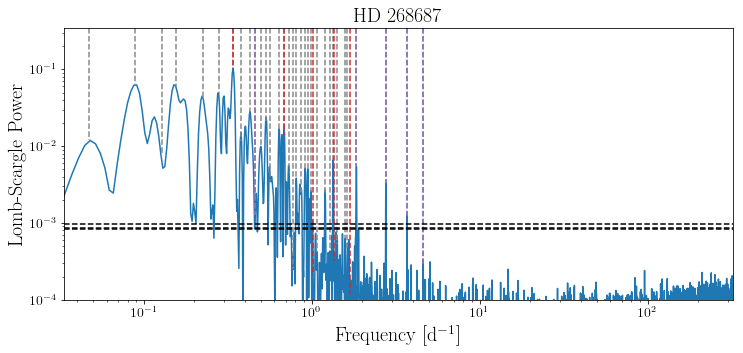

In [25]:
fig = plt.figure(figsize=(12,5))
lc, lc_smooth = lc_extract(get_lc_from_id(tic), smooth=128)
lc = polynorm(lc, deg=7)[0]
time, flux, err = lc['Time'], lc['NormFlux'], lc['NormErr']
ls = LombScargle(time, flux)
freq, power = ls.autopower() 
plt.loglog(freq, power)

ax = plt.gca()

ax.set(xlabel='Frequency [d$^{-1}$]',ylabel='Lomb-Scargle Power', xlim=(1/30,pseudo_NF))

ylim = ax.get_ylim()

plt.plot([good_fs[0,0],good_fs[0,0]],[ylim[1],power[np.argmin(np.abs(freq-good_fs[0,0]))]],c='#888888',ls='--',label='Prewhitening Frequencies')
for f in good_fs[1:,0]:
    plt.plot([f,f],[ylim[1],power[np.argmin(np.abs(freq-f))]],c='#888888',ls='--')
 
dom = 0.3398155918857977
plt.plot([dom,dom],[ylim[1],power[np.argmin(np.abs(freq-dom))]],c='C3',ls='--',label='$f=0.3398$ day$^{-1}$ and harmonics')
for i in range(2,6):
    plt.plot([i*dom,i*dom],[ylim[1],power[np.argmin(np.abs(freq-i*dom))]],c='C3',ls='--')
    
fund = harmonics[0,6]
harms = harmonics[1,6:]
plt.plot([fund,fund],[ylim[1],power[np.argmin(np.abs(freq-fund))]],c='C4',ls='--',label='$f=0.4609$ day$^{-1}$ and harmonics')
for h in harms:
    plt.plot([h,h],[ylim[1],power[np.argmin(np.abs(freq-h))]],c='C4',ls='--')
   
    
ax.set(ylim=(1e-4,ylim[1]))

probabilities = [0.1, 0.05, 0.01]
fal = ls.false_alarm_level(probabilities)
for f in fal:
    plt.axhline(y=f,c='k',ls='--')
        
#plt.legend(loc=1, framealpha=0.9, prop={'size': 14})

ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)

ax.set_title('HD 268687',fontsize=20) 

In [22]:
lc['Time']

TypeError: tuple indices must be integers or slices, not str